In [1]:
import pandas as pd
import numpy as np
from utils import reduce_memory_usage
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib
import zipfile
import os
import category_encoders
from sklearn.preprocessing import StandardScaler
import joblib
import zipfile
import os
import holidays
import wandb

warnings.filterwarnings('ignore')

# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

def percent_missing_val(df):

  percent_missing = (df.isnull().sum() * 600) / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df

def nan_fillers(df):
  air_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['air_temperature'].transform('mean')
  df['air_temperature'].fillna(air_temp_df, inplace=True)

  dew_temp_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['dew_temperature'].transform('mean')
  df['dew_temperature'].fillna(dew_temp_df, inplace=True)

  cloud_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['cloud_coverage'].transform('mean')
  df['cloud_coverage'].fillna(cloud_df, inplace=True)

  sea_level_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['sea_level_pressure'].transform('mean')
  df['sea_level_pressure'].fillna(sea_level_df, inplace=True)

  precip_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['precip_depth_1_hr'].transform('mean')
  df['precip_depth_1_hr'].fillna(precip_df, inplace=True)

  wind_dir_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_direction'].transform('mean')
  df['wind_direction'].fillna(wind_dir_df, inplace=True)

  wind_speed_df=df.groupby(['site_id', 'dayofweek', 'weekofyear'])['wind_speed'].transform('mean')
  df['wind_speed'].fillna(wind_speed_df, inplace=True)


  return df

def circular_encode(feature, max_value):
    sin_encoded = np.sin(2 * np.pi * feature / max_value)
    cos_encoded = np.cos(2 * np.pi * feature / max_value)
    return sin_encoded, cos_encoded,

df = df[df['site_id'].isin([1, 6])]
df['log_meter_reading']=np.log1p(df['meter_reading'])
df['log_square_feet']=np.log1p(df['square_feet'])
df= break_datetime(df)
df.drop(['year_built', 'floor_count'], axis=1,inplace=True)
df= nan_fillers(df)
df['cloud_coverage'].fillna(df['cloud_coverage'].median(), inplace=True)
df['sea_level_pressure'].fillna(df['sea_level_pressure'].median(), inplace=True)
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].median(), inplace=True)
df=df.sort_values(by='timestamp')
df['month_sin'], df['month_cos'] = circular_encode(df['month'], 12)
df['hour_sin'], df['hour_cos'] = circular_encode(df['hour'], 24)
df['dayofweek_sin'], df['dayofweek_cos'] = circular_encode(df['dayofweek'], 7)
label_enc= LabelEncoder()
label_enc.fit(df['primary_use'])
df['primary_use_encoded'] = label_enc.transform(df['primary_use'])
df['is_weekday']=df['dayofweek'] <= 5

In [2]:
df = df[["timestamp","site_id","building_id", "log_meter_reading"]]
df = df.groupby(['site_id', 'timestamp'])['log_meter_reading'].mean().reset_index()


In [3]:
data1 = df[df['site_id'] == 1]
data6 = df[df['site_id'] == 6]
data1 = data1.sort_values(by='timestamp')
data6 = data6.sort_values(by='timestamp')

In [6]:
data6 = data6.reset_index()
data6

,index,site_id,timestamp,log_meter_reading
0,8784,6,2016-01-01 00:00:00,4.281729
1,8785,6,2016-01-01 01:00:00,4.271355
2,8786,6,2016-01-01 02:00:00,4.267159
3,8787,6,2016-01-01 03:00:00,4.269478
4,8788,6,2016-01-01 04:00:00,4.278094
...,...,...,...,...
8778,17562,6,2016-12-31 19:00:00,4.391754
8779,17563,6,2016-12-31 20:00:00,4.365319
8780,17564,6,2016-12-31 21:00:00,4.354705
8781,17565,6,2016-12-31 22:00:00,4.349384


# WandB Site-6

In [5]:
window_size = 19  # Choose an appropriate window size
prediction_window = 2 * 30 * 24  # Two months of data assuming hourly data

# Calculate moving averages for the entire dataset initially
data6['rolling_mean'] = data6['log_meter_reading'].rolling(window=window_size).mean()

# Determine the start and end indices for the last two months of data
end_index = len(data6)
start_index = end_index - prediction_window

# Initialize the 'predictions' column with NaN values
data6['predictions'] = np.nan

# Determine the start and end indices for the last two months of data
end_index = len(data6)
start_index = end_index - prediction_window

for window_size in window_sizes:
    # Calculate moving averages for the entire dataset initially
    data6['rolling_mean'] = data6['log_meter_reading'].rolling(window=window_size).mean()

    # Determine the start and end indices for the last two months of data
    end_index = len(data6)
    start_index = end_index - prediction_window

    # Perform predictions for the last two months of data using the calculated moving averages
    predictions = []

    for i in range(start_index, end_index):
        last_known_values = data6['rolling_mean'].iloc[i - window_size:i]
        next_prediction = last_known_values.mean()
        predictions.append(next_prediction)

    # Calculate performance metrics (MAE, MSE, MAPE, R2)
    mae = mean_absolute_error(data6['log_meter_reading'].iloc[start_index:end_index], predictions)
    mse = mean_squared_error(data6['log_meter_reading'].iloc[start_index:end_index], predictions)

    actual = data6['log_meter_reading'].iloc[start_index:end_index]
    mape = np.mean(np.abs((actual - predictions) / (actual + 1e-10))) * 100
    r2 = r2_score(actual, predictions)

    # Log window size and metrics to WandB
    wandb.log({'window_size': window_size, 'mae': mae, 'mse': mse, 'mape': mape, 'r2': r2})


# Finish the WandB run
wandb.finish()

mae,▁█▃▂▃▄▄▄▄▄▄▅▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
mape,▁█▃▃▃▄▄▄▄▄▄▅▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
mse,▁█▃▂▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆
r2,█▁▆▇▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃
window_size,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mae,0.13651
mape,3.01486
mse,0.02498
r2,-0.11648
window_size,299


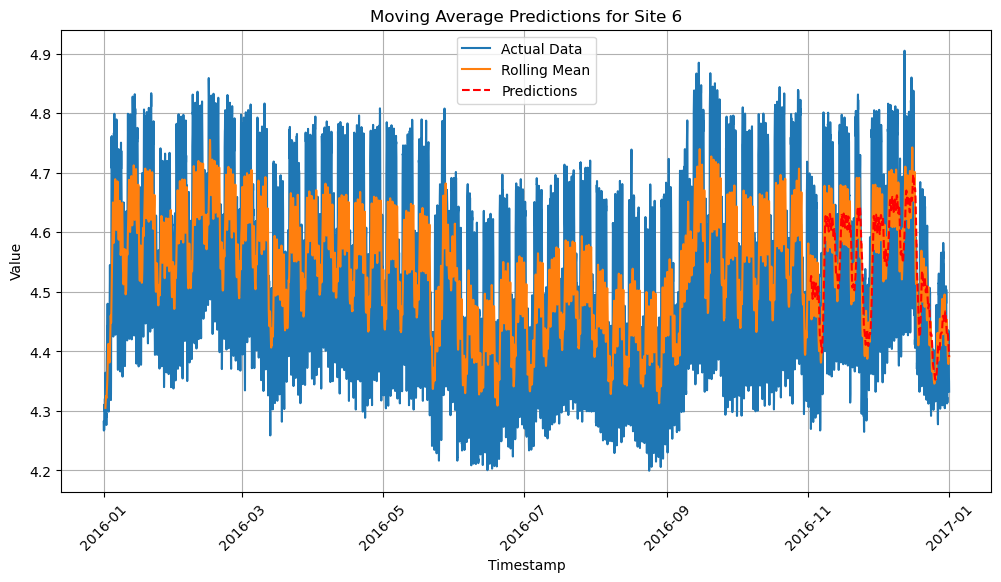

In [10]:
window_size = 19  # Choose an appropriate window size
prediction_window = 2 * 30 * 24  # Two months of data assuming hourly data

# Calculate moving averages for the entire dataset initially
data6['rolling_mean'] = data6['log_meter_reading'].rolling(window=window_size).mean()

# Initialize the 'predictions' column with NaN values
data6['predictions'] = np.nan

# Determine the start and end indices for the last two months of data
end_index = len(data6)
start_index = end_index - prediction_window

for i in range(start_index, end_index):
    last_known_values = data6['rolling_mean'].iloc[i - window_size:i]
    next_prediction = last_known_values.mean()
    data6.at[i, 'predictions'] = next_prediction

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data6['timestamp'], data6['log_meter_reading'], label='Actual Data')
plt.plot(data6['timestamp'], data6['rolling_mean'], label='Rolling Mean')
plt.plot(data6['timestamp'], data6['predictions'], label='Predictions', linestyle='dashed', color='red')
plt.title('Moving Average Predictions for Site 6')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [8]:
data

,site_id,timestamp,log_meter_reading,rolling_mean,predictions
8784,6.0,2016-01-01 00:00:00,4.281729,NaN,NaN
8785,6.0,2016-01-01 01:00:00,4.271355,NaN,NaN
8786,6.0,2016-01-01 02:00:00,4.267159,NaN,NaN
8787,6.0,2016-01-01 03:00:00,4.269478,NaN,NaN
8788,6.0,2016-01-01 04:00:00,4.278094,NaN,NaN
...,...,...,...,...,...
8778,NaN,NaT,NaN,NaN,4.402840
8779,NaN,NaT,NaN,NaN,4.399205
8780,NaN,NaT,NaN,NaN,4.395936
8781,NaN,NaT,NaN,NaN,4.393205
